# Test of MoGe and SAM2

### Imports

In [36]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image

import open3d as o3d
from trimesh import Trimesh
import trimesh

from moge.model.v2 import MoGeModel
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from utils import get_integer_segments, plot_region_numbers, triangulate_segments

### Define devices and functions

In [3]:
device0 = torch.device("cuda:0")
device1 = torch.device("cuda:1")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [4]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

### Load models

In [99]:
sam2_checkpoint = "../models/SAM2/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device0, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [6]:
moge_model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device0)

### Add input image

In [7]:
# Read the input image and convert to tensor (3, H, W) with RGB values normalized to [0, 1]
input_image = cv2.cvtColor(cv2.imread("../data/mustard360/images/frame_0.png"), cv2.COLOR_BGR2RGB)                       
input_image_tensor = torch.tensor(input_image / 255, dtype=torch.float32, device=device0).permute(2, 0, 1)
input_image_array  = np.array(input_image)

### Infer segmentation masks and estimate geometry

In [100]:
masks = mask_generator.generate(input_image_array)

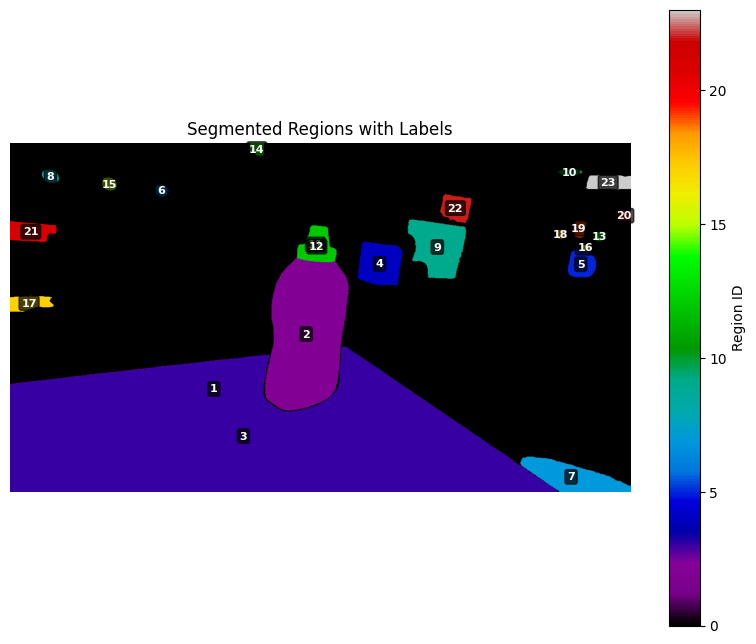

In [101]:
segmentation_masks = [mask['segmentation'] for mask in masks]
segmentation_masks = np.array(segmentation_masks)

int_seg = get_integer_segments(segmentation_masks)
plot_region_numbers(int_seg)

In [10]:
output = moge_model.infer(input_image_tensor)
"""
`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",
The maps are in the same size as the input image. 
{
    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.
    "depth": (H, W),        # depth map
    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)
    "mask": (H, W),         # a binary mask for valid pixels. 
    "intrinsics": (3, 3),   # normalized camera intrinsics
}
"""

'\n`output` has keys "points", "depth", "mask", "normal" (optional) and "intrinsics",\nThe maps are in the same size as the input image. \n{\n    "points": (H, W, 3),    # point map in OpenCV camera coordinate system (x right, y down, z forward). For MoGe-2, the point map is in metric scale.\n    "depth": (H, W),        # depth map\n    "normal": (H, W, 3)     # normal map in OpenCV camera coordinate system. (available for MoGe-2-normal)\n    "mask": (H, W),         # a binary mask for valid pixels. \n    "intrinsics": (3, 3),   # normalized camera intrinsics\n}\n'

In [49]:
def crop_by_sp(segment_id:int,
               integer_segments:np.ndarray,
               image:np.ndarray, points:np.ndarray,
               border=0,
               remove_other_segs=True) -> tuple[np.ndarray, np.ndarray]:
    """Crops the segmentation, colour and, 3D point arrays to the bounding rectangle around a particular segment.

    Args:
        segment_id (int): the integer related to the superprimitive to be cropped around
        image (np.ndarray): original colour image to be correspondingly cropped
        integer_segments (np.ndarray): segmentation masks in integer format (each segment made of a different integer)
        points (np.ndarray): 3D points in (H,W,3) format

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: cropped segmentation, image, and points arrays
    """
    if integer_segments.ndim != 2:
        raise ValueError("integer_segments must be 2-D (H, W).")
    if image.ndim != 3 or image.shape[2] != 3:
        raise ValueError("image must be shape (H, W, 3)")
    if points.ndim != 3 or points.shape[2] != 3:
        raise ValueError("points must be shape (H, W, 3)")
    if points.shape != image.shape:
        raise ValueError("points and image shapes must match")
    if points.shape[:2] != integer_segments.shape:
        raise ValueError("integer_segments shape must match image and points shapes")

    temp_segs = integer_segments.copy()
    
    # Locate all pixels in the desired segment
    mask = temp_segs == segment_id
    if not mask.any():
        raise ValueError(f"segment_id {segment_id} not found in integer_segments.")
    
    if remove_other_segs:
        temp_segs[~mask] = 0
    
    # Bounding rows and columns
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    r_min, r_max = rows[0], rows[-1]
    c_min, c_max = cols[0], cols[-1]

    # Slice both arrays
    seg_crop = temp_segs[r_min - border : r_max + border + 1, c_min - border : c_max + border + 1]
    img_crop =     image[r_min - border : r_max + border + 1, c_min - border : c_max + border + 1]
    pts_crop =    points[r_min - border : r_max + border + 1, c_min - border : c_max + border + 1, :]

    return seg_crop, img_crop, pts_crop


### Show outputs

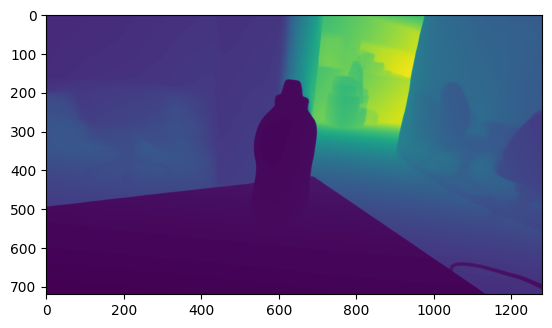

In [10]:
plt.imshow(output["depth"].cpu())

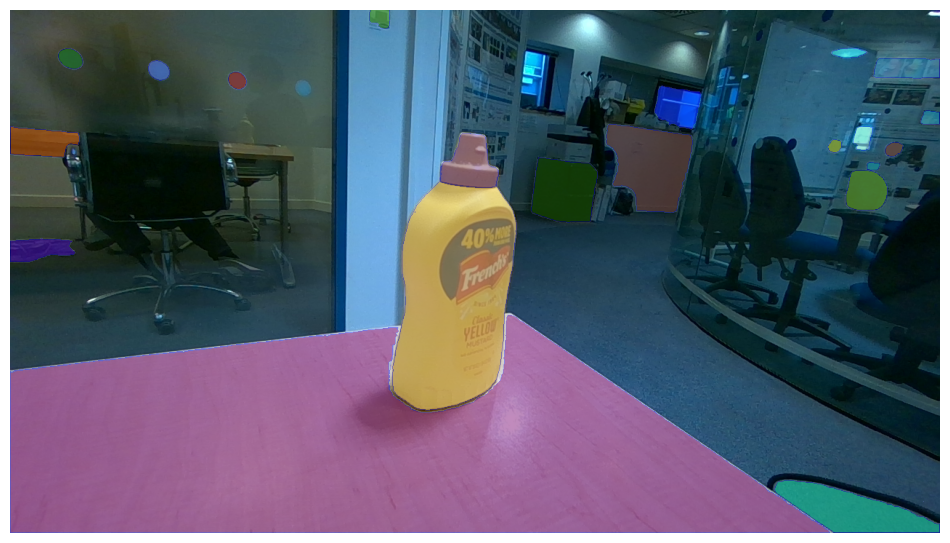

In [102]:
plt.figure(figsize=(12,12))
plt.imshow(input_image_array)
show_anns(masks)
plt.axis('off')
plt.show() 

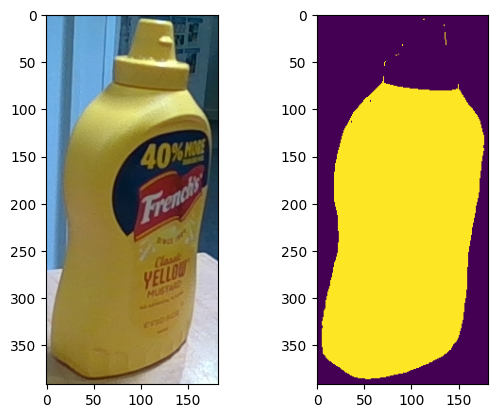

In [103]:
int_seg_cropped, img_cropped, points_cropped = crop_by_sp(2, int_seg, input_image, output['points'], border=5)
# plt.imshow(int_seg_cropped)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_cropped)
axarr[1].imshow(int_seg_cropped)

In [104]:
verts_cropped = points_cropped.reshape((-1,3)).cpu().numpy()

pcd = o3d.geometry.PointCloud()
pcd.points  = o3d.utility.Vector3dVector(verts_cropped)

o3d.visualization.draw_geometries([pcd])

In [105]:
tris = triangulate_segments(verts_cropped, int_seg_cropped)

In [106]:
colours_cropped = np.clip(img_cropped, 0, 255).reshape((-1,3)).astype(np.uint8, casting='unsafe')
alpha_channel = 255*np.ones((np.prod(img_cropped.shape[:2]),1), dtype=np.uint8)
colours_cropped = np.hstack([colours_cropped, alpha_channel])

In [107]:
all_tris = [tri for trise in tris for tri in trise]
mesh = Trimesh(vertices=verts_cropped, faces=all_tris, vertex_colors=colours_cropped)
meshes = [Trimesh(vertices=verts_cropped, faces=individual_tris, vertex_colors=colours_cropped) for individual_tris in tris]

In [140]:
def filter_triangles(verts: np.ndarray,
                     tris: np.ndarray,
                     max_edge_ratio: float = 2.0,
                     min_quality: float = 0.2) -> np.ndarray:
    """
    Remove triangles that are either stretched (long/short edge ratio)
    or degenerate (skinny quality metric).

    Args:
        verts: (K, 3) input vertices
        tris (ndarray): (N, 3) array of triangles to be filtered
        max_edge_ratio (float): Longest / shortest edge ratio allowed (e.g. 2.0).
        min_quality (float): Minimum area-based quality metric q to keep (e.g. 0.2).

    Returns:
    (M, 3) ndarray: Triangles that pass both criteria.
    """
    tris = np.asarray(tris, dtype=np.intp)
    p = verts[tris] # (N, 3, 3)

    v01 = p[:, 1] - p[:, 0]
    v12 = p[:, 2] - p[:, 1]
    v20 = p[:, 0] - p[:, 2]

    # Squared edge lengths
    a2 = np.einsum('ij,ij->i', v01, v01)
    b2 = np.einsum('ij,ij->i', v12, v12)
    c2 = np.einsum('ij,ij->i', v20, v20)

    # Stretched-edge test
    ratio2 = np.maximum.reduce([a2, b2, c2]) / np.minimum.reduce([a2, b2, c2])
    stretched_ok = ratio2 <= max_edge_ratio**2

    # Skinny-triangle quality test
    area = 0.5 * np.linalg.norm(np.cross(v01, v12), axis=1)
    quality = 4 * np.sqrt(3) * area / (a2 + b2 + c2)
    quality_ok = quality >= min_quality
    
    print(np.sum(~(stretched_ok & quality_ok)))

    return tris[stretched_ok & quality_ok]

tris_filtered = filter_triangles(verts_cropped, all_tris, max_edge_ratio=1000, min_quality=0.2)
mesh_filtered = Trimesh(vertices=verts_cropped, faces=tris_filtered, vertex_colors=colours_cropped)
mesh_filtered.show()

1972


In [143]:
def strip_disconnected_triangles(verts: np.ndarray,
                                 tris:  np.ndarray) -> np.ndarray:
    """
    Remove "floating" / unconnected triangles, keeping only the faces that
    belong to the largest connected component of the mesh.

    Args:
        verts: (K, 3) input vertices
        tris (ndarray): (N, 3) array of triangles to be filtered

    Returns:
        ndarray: (M, 3) Faces of the main component (M <= N).
    """
    tris   = np.asarray(tris, dtype=np.intp)
    n_vert = verts.shape[0]

    # Union–Find (disjoint-set)
    parent = np.arange(n_vert, dtype=np.intp)

    def find(x):
        # Path-compressed root finder
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    # Union the three edges of every triangle
    v0, v1, v2 = tris.T          # unpack once (views, no copy)
    for a, b in np.stack([np.stack([v0, v1], 1),
                          np.stack([v1, v2], 1),
                          np.stack([v2, v0], 1)], axis=1).reshape(-1, 2):
        union(a, b)

    # Component label of each vertex and hence of each triangle
    comp_of_vert = np.frompyfunc(find, 1, 1)(np.arange(n_vert)).astype(np.intp)
    comp_of_tri  = comp_of_vert[tris[:, 0]] # all 3 verts share the same root

    # Identify the largest component by face count
    biggest_comp = np.bincount(comp_of_tri).argmax()

    print(np.sum(comp_of_tri != biggest_comp))

    # Keep only faces of that component
    return tris[comp_of_tri == biggest_comp]

main_tris = strip_disconnected_triangles(verts_cropped, tris_filtered)
mesh_main = Trimesh(vertices=verts_cropped,
                    faces=main_tris,
                    vertex_colors=colours_cropped)
mesh_main.show()

44
